In [1]:
import numpy as np
import scipy as sp
import pickle as pkl
import networkx as nx
from py2neo import Graph
import py2neo
import pandas as pd
import nxviz as nv
import matplotlib.pyplot as plt
from stellargraph import StellarGraph
from BiRank import BiRank
import shap
import networkit

from tqdm.notebook import tqdm


%matplotlib inline

C:\Users\bruno\anaconda3\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.0 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.0, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
claims_data = pkl.load(open( "claims_data", "rb" ))
counterparty_data = pkl.load(open("counterparties", "rb"))
labels = pkl.load(open("frauds", "rb")).sort_values("SI01_NO_SIN")

In [5]:
len(counterparty_data[counterparty_data["C-NAT-INTVT"]=="CL"]["NO-SIN"].unique()) == len(claims_data["SI01_NO_SIN"])

True

In [6]:
claims_data = pkl.load(open( "claims_data", "rb" ))
counterparty_data = pkl.load(open("counterparties", "rb"))
labels = pkl.load(open("frauds", "rb")).sort_values("SI01_NO_SIN")

claims_nodes = claims_data[["SI01_NO_SIN"]].drop_duplicates().set_index("SI01_NO_SIN").sort_values("SI01_NO_SIN")
contract_nodes = claims_data[["SI01_NO_CNT"]].drop_duplicates().set_index("SI01_NO_CNT")
broker_nodes = claims_data[["SI01_C_INTER"]].drop_duplicates().set_index("SI01_C_INTER")

counterparty_nodes = counterparty_data[["C-TIE"]].drop_duplicates()
counterparty_nodes = counterparty_nodes[[cp not in broker_nodes.index for cp in counterparty_nodes["C-TIE"]]]
counterparty_nodes = counterparty_nodes.set_index("C-TIE")

claim_contract = claims_data[["SI01_NO_SIN", "SI01_NO_CNT"]].reset_index(drop=True)
claim_broker = claims_data[["SI01_NO_SIN", "SI01_C_INTER"]].reset_index(drop=True)
claim_counter = counterparty_data[["NO-SIN", "C-TIE"]].reset_index(drop=True)

claim_contract.columns = ["source", "target"]
claim_broker.columns = ["source", "target"]
claim_counter.columns = ["source", "target"]

edges = pd.concat([claim_contract, claim_broker,claim_counter]).reset_index(drop = True)

In [13]:
counterparty_data.head()

,NO-SIN,C-TIE,C-NAT-INTVT,IMM,MRQ-ADV,PUISS-KW
0,000020182003590,0009700,CI,0.0,,0000
1,000020182003590,000000000612615,CL,0.0,,0000
2,000020182003590,000000005135071,TI,305832.0,,0000
3,000020192013964,000000008837733,CL,0.0,,0000
4,000020171035446,000000009145429,CL,219542.0,PEUG PARTNER,0044


In [14]:
HG = StellarGraph({"claim" : claims_nodes, "contract" : contract_nodes, "broker" : broker_nodes, "counterparty" : counterparty_nodes}, edges)

In [15]:
nodes = list(HG.nodes("claim"))+list(HG.nodes("contract"))+list(HG.nodes("broker"))+list(HG.nodes("counterparty"))

adjmat_bipartite = HG.to_adjacency_matrix(nodes)[:len(HG.nodes("claim")), len(HG.nodes("claim")):]

# The base model

In [16]:
from datetime import timedelta

In [17]:
reporting_delay =[min(timedelta(days = 90), delay) for delay in claims_data["SI01_D_DCL"]-claims_data["SI01_D_SURV_SIN"]]
claims_data["Reporting_delay"] = reporting_delay

claims_data["Day_Accident"] = claims_data["SI01_D_SURV_SIN"].dt.weekday
claims_data["Month_Accident"] = claims_data["SI01_D_SURV_SIN"].dt.month

claims_data["SI01_H_SIN"].replace(0, pd.NA, inplace = True)
decimal_hours = claims_data["SI01_H_SIN"]//100+claims_data["SI01_H_SIN"]%100/60

#Some wrong hours. This is set to 0 = <NA>
raw_hours = [round(h,2) if (str(h) != '<NA>') & (str(h) != 'nan') else 12 for h in decimal_hours ]
claims_data["Closest_Hour"] = [h if h<= 24 else 0 for h in raw_hours]

In [18]:
claims_data["Closest_Hour"].max()

23.98

In [19]:
merged_cl_fr = claims_data.merge(labels.reset_index()[["SI01_NO_SIN", "Proven_fraud"]],on = "SI01_NO_SIN")
merged_cl_fr.head()

,SI01_NO_SIN,SI01_NO_CNT,SI01_C_INTER,IMM,SI01_CPOST,SI01_C_CAU,SI01_D_DCL,SI01_NB_HIST,SI01_NB_EXPE,SI01_H_SIN,SI01_C_FAM_PROD,SI01_D_SURV_SIN,Reporting_delay,Day_Accident,Month_Accident,Closest_Hour,Proven_fraud
0,000020182003590,020303009036928,15105301,0.0,3150.0,12,2018-03-17,0,0,<NA>,I01,2018-03-12,5 days,0,3,12.0,0.0
1,000020192013964,021002200311628,10341001,0.0,1180.0,19,2019-12-16,0,0,<NA>,I05,2019-02-11,90 days,0,2,12.0,0.0
2,000020171035446,010102100896928,40007101,219542.0,4040.0,50,2017-08-29,0,0,1500.0,A01,2017-08-22,7 days,1,8,15.0,0.0
3,000020132004578,020602200105863,10109201,0.0,1070.0,19,2013-06-03,0,0,<NA>,I01,2013-05-31,3 days,4,5,12.0,0.0
4,000020171057502,011002100887089,15322601,111552.0,5000.0,SS,2018-01-19,1,1,<NA>,A01,2017-09-01,90 days,4,9,12.0,0.0


In [20]:
selected_features = ["SI01_NO_SIN",
                     "SI01_C_CAU", 
                     "SI01_C_FAM_PROD",
                     "Reporting_delay",
                     "Day_Accident", 
                     "Month_Accident",
                     "Closest_Hour"]

df = merged_cl_fr.sort_values("SI01_NO_SIN")[selected_features]
df.head()

,SI01_NO_SIN,SI01_C_CAU,SI01_C_FAM_PROD,Reporting_delay,Day_Accident,Month_Accident,Closest_Hour
107257,000020111059354,ER,A01,51 days,1,1,12.0
297320,000020111059939,10,A01,4 days,0,4,17.0
395615,000020112015244,13,I01,20 days,2,1,12.0
423673,000020121000009,64,A02,1 days,0,1,12.0
178103,000020121000011,76,A01,0 days,1,1,12.0


In [21]:
selected_features = ["SI01_NO_SIN",
                     "SI01_C_CAU", 
                     "SI01_C_FAM_PROD",
                     "Reporting_delay",
                     "Day_Accident", 
                     "Month_Accident",
                     "Closest_Hour"]

df = merged_cl_fr.sort_values("SI01_NO_SIN")[selected_features]#.reset_index(drop = True)

all_columns =  set(df.columns)
numeric_columns = set(df.describe().columns)
factor_columns = all_columns.difference(numeric_columns).difference(set(["SI01_NO_SIN"]))
print(factor_columns)

{'SI01_C_FAM_PROD', 'SI01_C_CAU'}


In [22]:
from sklearn.preprocessing import OrdinalEncoder
columns = [*factor_columns]
first_column = columns[0]
for column in columns:
    print(column)
    enc = OrdinalEncoder()
    X_encoder = enc.fit(df[[column]])
    X_encoded = X_encoder.transform(df[[column]])
    if column == first_column:
        X_full_encoded = X_encoded
    else:
        X_full_encoded = np.hstack((X_full_encoded, X_encoded))
        
X_full_encoded = np.hstack((X_full_encoded, df[["SI01_NO_SIN"]]))

SI01_C_FAM_PROD
SI01_C_CAU


In [23]:
X_full_encoded_df = pd.DataFrame(X_full_encoded)
columns.append("SI01_NO_SIN")
X_full_encoded_df.columns = columns
X_full_encoded_df.head()

,SI01_C_FAM_PROD,SI01_C_CAU,SI01_NO_SIN
0,0.0,77.0,000020111059354
1,0.0,8.0,000020111059939
2,12.0,11.0,000020112015244
3,1.0,55.0,000020121000009
4,0.0,67.0,000020121000011


In [24]:
columns_numeric = [*numeric_columns]
columns_numeric.append("SI01_NO_SIN")
df_full = df[columns_numeric].merge(X_full_encoded_df, on = "SI01_NO_SIN")
df_full['Reporting_delay']=df_full['Reporting_delay'].dt.days
df_full = df_full.merge(merged_cl_fr[["SI01_NO_SIN","Proven_fraud"]], on = "SI01_NO_SIN").sort_values("SI01_NO_SIN")

In [25]:
df_full.head()

,Month_Accident,Day_Accident,Closest_Hour,Reporting_delay,SI01_NO_SIN,SI01_C_FAM_PROD,SI01_C_CAU,Proven_fraud
0,1,1,12.0,51,000020111059354,0.0,77.0,0.0
1,4,0,17.0,4,000020111059939,0.0,8.0,0.0
2,1,2,12.0,20,000020112015244,12.0,11.0,0.0
3,1,0,12.0,1,000020121000009,1.0,55.0,0.0
4,1,1,12.0,0,000020121000011,0.0,67.0,0.0


In [26]:
X_full = df_full[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU"]]
y_full = df_full["Proven_fraud"]

In [27]:
train_size = int(round(0.6*len(y_full),0))

X_train = X_full.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [29]:
from EvaluationFunctions import lift_curve_values,complementarity_measure

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0530          -0.0002           14.51s
         2           0.0544           0.0001           14.47s
         3           0.0537           0.0001           14.25s
         4           0.0536           0.0000           14.10s
         5           0.0537           0.0001           14.02s
         6           0.0531           0.0001           13.80s
         7           0.0535           0.0002           13.66s
         8           0.0520           0.0000           13.69s
         9           0.0534           0.0002           13.63s
        10           0.0530           0.0003           13.51s
        20           0.0517           0.0001           11.79s
        30           0.0501          -0.0000           10.24s
        40           0.0508           0.0000            8.78s
        50           0.0507           0.0000            7.32s
        60           0.0504          -0.0000            5.85s
       

Text(0.5, 1.0, 'AUC: 0.752')

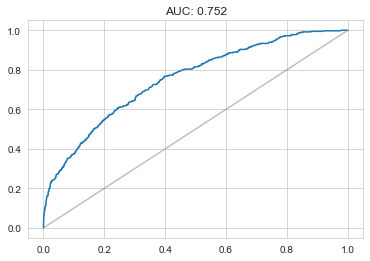

In [30]:
basic_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = basic_model.predict_proba(X_test)[:,1]
fpr_base, tpr_base, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr_base,tpr_base)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr_base, tpr_base),3)))
#plt.savefig("AUC_simple_model.pdf")

In [31]:
y_base_pred = y_pred

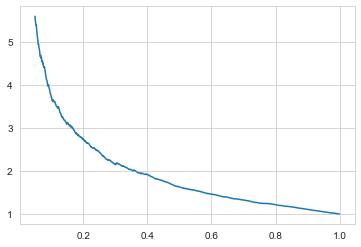

In [32]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft_base = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)

Text(0.5, 1.0, 'Average Precision: 0.012')

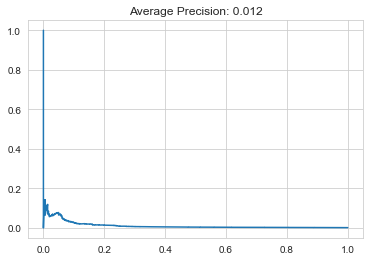

In [33]:
precision_base, recall_base, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall_base,precision_base)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))
#plt.savefig("AP_simple_model.pdf")

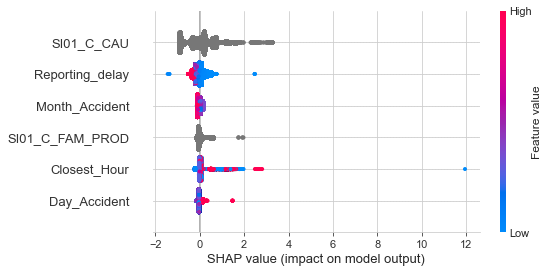

In [34]:
shap_values = shap.TreeExplainer(basic_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, show = False)
plt.tight_layout()
plt.savefig("First_Shap_test.pdf")

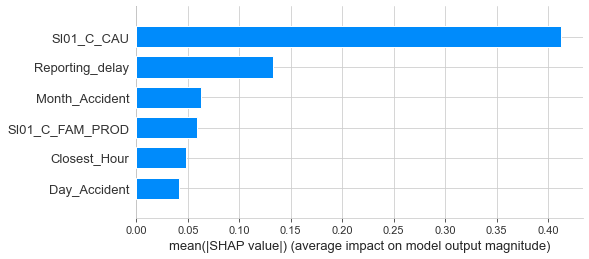

In [35]:
shap.summary_plot(shap_values, X_test, plot_type ="bar")

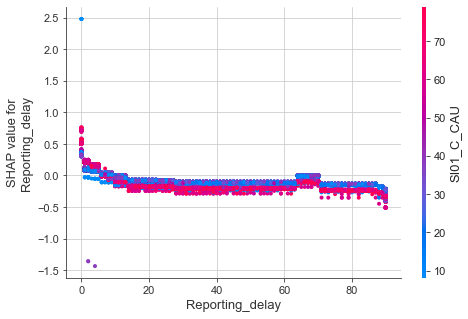

In [36]:
shap.dependence_plot("Reporting_delay", shap_values, X_test, show=False)
plt.savefig("Shap_reporting_delay_test.pdf")

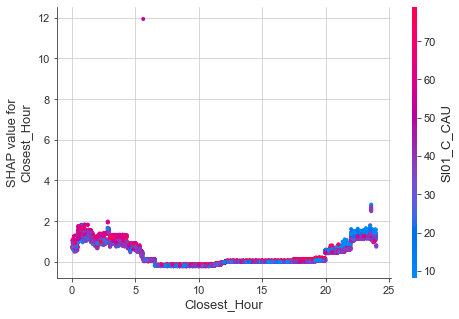

In [37]:
shap.dependence_plot("Closest_Hour", shap_values, X_test, show=False)
plt.savefig("Shap_Closest_Hour_test.pdf")

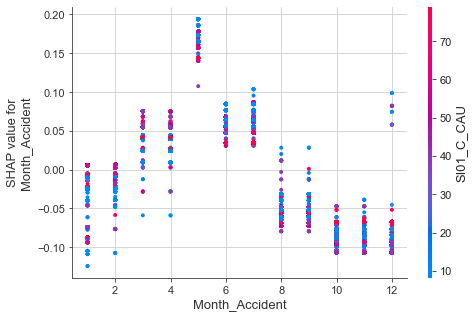

In [38]:
shap.dependence_plot("Month_Accident", shap_values, X_test, show=False)
plt.savefig("Shap_Month_Accident_test.pdf")

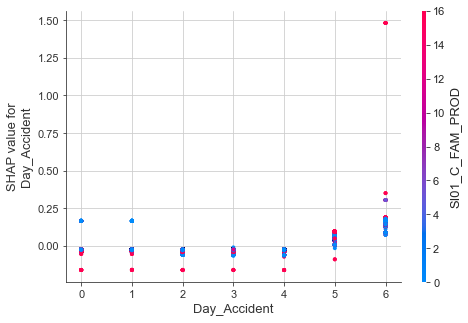

In [39]:
shap.dependence_plot("Day_Accident", shap_values, X_test, show=False)
plt.savefig("Shap_Day_Accident_test.pdf")

# Simple Features

### Counterparties

In [40]:
counterparty_data_df = pd.pivot_table(counterparty_data, index = "NO-SIN", values = "C-TIE", columns = "C-NAT-INTVT", aggfunc='count').fillna(0)
counterparty_data_df.columns= np.sort(counterparty_data["C-NAT-INTVT"].unique())
counterparty_data_df = counterparty_data_df[["AD", "TI", "TE"]] #No lawyer
counterparty_data_df.reset_index(drop = False, inplace = True)
counterparty_data_df.head()

,NO-SIN,AD,TI,TE
0,000020111059354,0.0,0.0,0.0
1,000020111059939,0.0,0.0,0.0
2,000020112015244,0.0,0.0,0.0
3,000020121000009,0.0,1.0,0.0
4,000020121000011,0.0,0.0,0.0


In [42]:
df_full_simple = pd.merge(df_full, counterparty_data_df, left_on = "SI01_NO_SIN", right_on = "NO-SIN")

In [43]:
df_full_simple = df_full_simple.drop(df_full_simple[["NO-SIN"]], axis = 1).sort_values("SI01_NO_SIN")

In [44]:
df_full_simple.head()

,Month_Accident,Day_Accident,Closest_Hour,Reporting_delay,SI01_NO_SIN,SI01_C_FAM_PROD,SI01_C_CAU,Proven_fraud,AD,TI,TE
0,1,1,12.0,51,000020111059354,0.0,77.0,0.0,0.0,0.0,0.0
1,4,0,17.0,4,000020111059939,0.0,8.0,0.0,0.0,0.0,0.0
2,1,2,12.0,20,000020112015244,12.0,11.0,0.0,0.0,0.0,0.0
3,1,0,12.0,1,000020121000009,1.0,55.0,0.0,0.0,1.0,0.0
4,1,1,12.0,0,000020121000011,0.0,67.0,0.0,0.0,0.0,0.0


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0530          -0.0002           15.60s
         2           0.0544           0.0001           16.18s
         3           0.0537           0.0001           15.80s
         4           0.0536          -0.0000           15.53s
         5           0.0538           0.0000           15.39s
         6           0.0532           0.0000           15.23s
         7           0.0537           0.0002           15.04s
         8           0.0521           0.0000           14.90s
         9           0.0537           0.0000           14.78s
        10           0.0536           0.0000           14.66s
        20           0.0520           0.0001           12.98s
        30           0.0505           0.0000           11.33s
        40           0.0512           0.0000            9.69s
        50           0.0509           0.0000            8.07s
        60           0.0506           0.0000            6.46s
       

Text(0.5, 1.0, 'AUC: 0.75')

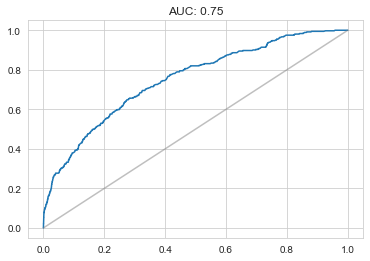

In [45]:
X_full = df_full_simple[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU",
                 "AD", "TI", "TE"]]

y_full = df_full_simple['Proven_fraud']

X_train = X_full.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

simple_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = simple_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_simple_network_model.pdf")

Text(0.5, 1.0, 'Average Precision: 0.011')

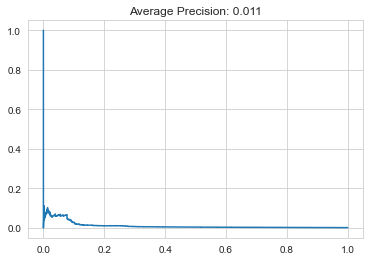

In [46]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))
#plt.savefig("AP_simple_network_model.pdf")

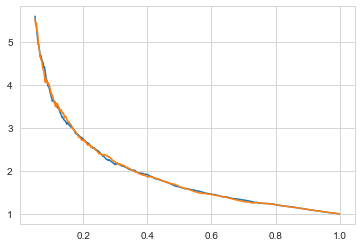

In [47]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)

In [48]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

In [49]:
percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)
    print(str(int(round(p*100,0)))+"%: "+str(round(comp_12,2))+", "+str(round(comp_21,2)))

1%: 0.33, 0.21
5%: 0.11, 0.1
10%: 0.08, 0.09
20%: 0.07, 0.06
50%: 0.02, 0.03


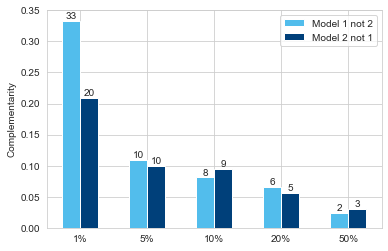

In [50]:
percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_simple.pdf")
plt.show()

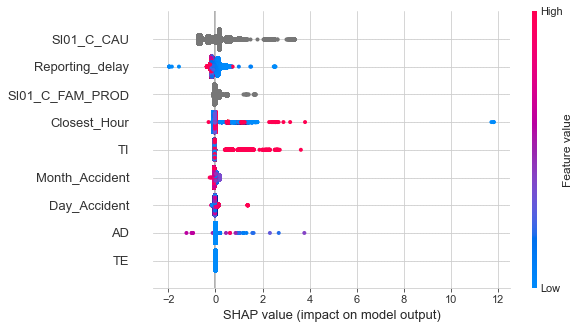

In [51]:
shap_values = shap.TreeExplainer(simple_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

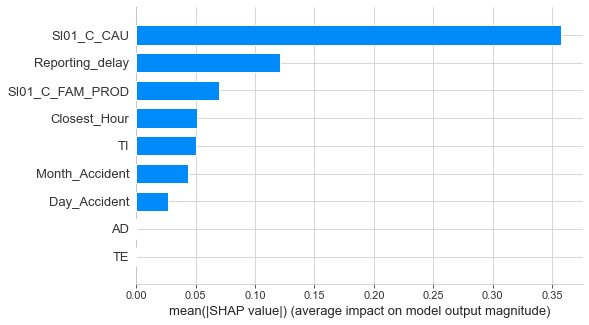

In [52]:
shap.summary_plot(shap_values, X_train, plot_type = "bar")

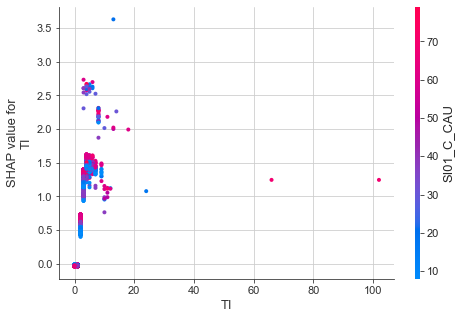

In [53]:
shap.dependence_plot("TI", shap_values, X_train,show=False)
#plt.savefig("Shap_TI.pdf")

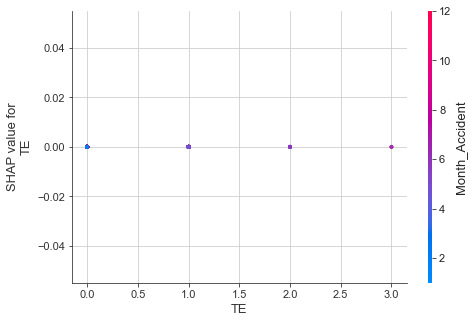

In [54]:
shap.dependence_plot("TE", shap_values, X_train, show=False)
#plt.savefig("Shap_TE.pdf")

### Geodesic distance

In [55]:
from BipartiteFunctions import geodesic

The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.


In [56]:
nodes_nobrokers = list(claims_nodes.index)+list(contract_nodes.index)+list(counterparty_nodes.index)
HG_nobrokers = HG.subgraph(nodes_nobrokers)
Nx_bipartite_nobrokers = HG_nobrokers.to_networkx()

In [57]:
full_geo_G = geodesic(Nx_bipartite_nobrokers)

In [58]:
Geo_claims = full_geo_G[full_geo_G['Item'].isin(HG.nodes("claim"))]

In [59]:
full_geo_claims = pd.DataFrame({"Item":HG.nodes("claim")}).merge(Geo_claims, on = "Item", how = "outer").fillna(0)

In [61]:
df_full_geo = pd.merge(df_full_simple, full_geo_claims, left_on = "SI01_NO_SIN", right_on = "Item")
df_full_geo = df_full_geo.drop(df_full_geo[["Item"]], axis = 1).sort_values("SI01_NO_SIN")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0528           0.0003           42.46s
         2           0.0541           0.0001           40.37s
         3           0.0537          -0.0000           34.47s
         4           0.0534          -0.0000           31.50s
         5           0.0535           0.0001           29.30s
         6           0.0530           0.0001           27.92s
         7           0.0535           0.0000           26.93s
         8           0.0519           0.0002           26.40s
         9           0.0534           0.0000           25.68s
        10           0.0534           0.0000           25.19s
        20           0.0516           0.0000           21.23s
        30           0.0504          -0.0000           18.36s
        40           0.0507           0.0001           15.33s
        50           0.0507           0.0000           12.85s
        60           0.0503           0.0000           10.24s
       

Text(0.5, 1.0, 'AUC: 0.768')

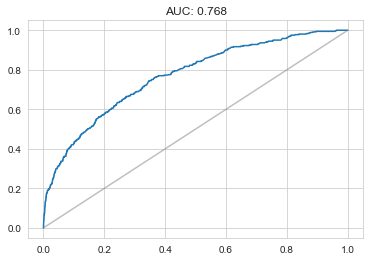

In [62]:
X_full = df_full_geo[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU",
                 "AD", "TI", "TE",
                     "Geodesic distance", "Number of cycles"]]

y_full = df_full_geo['Proven_fraud']

X_train = X_full.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

cycle_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = cycle_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

#plt.savefig("AUC_geo_model.pdf")

Text(0.5, 1.0, 'Average Precision: 0.01')

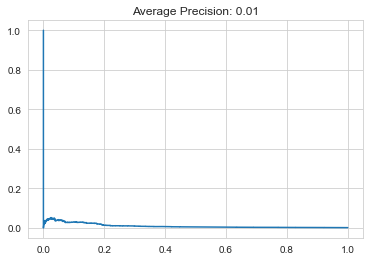

In [63]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))

#plt.savefig("AP_geo_model.pdf")

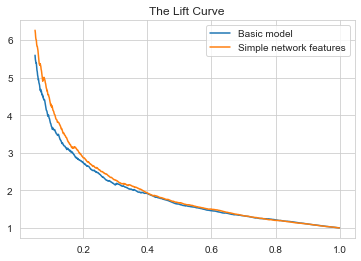

In [64]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "Simple network features"))
plt.savefig("Lift_geo.pdf")

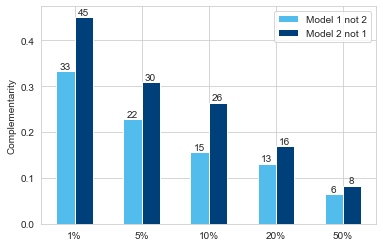

In [65]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_geo.pdf")
plt.show()

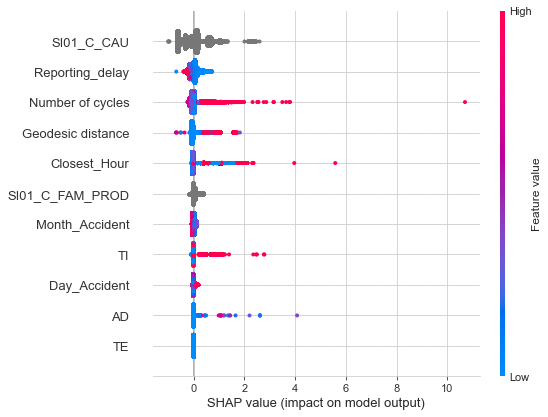

In [66]:
shap_values = shap.TreeExplainer(cycle_model).shap_values(X_train,check_additivity=False)
shap.summary_plot(shap_values, X_train, show = False)
plt.tight_layout()
plt.savefig("Summary_geo.pdf")

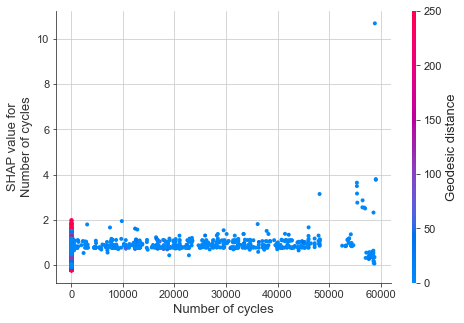

In [67]:
shap.dependence_plot("Number of cycles", shap_values, X_train, show=False)
#plt.savefig("Shap_NumCycles.pdf")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


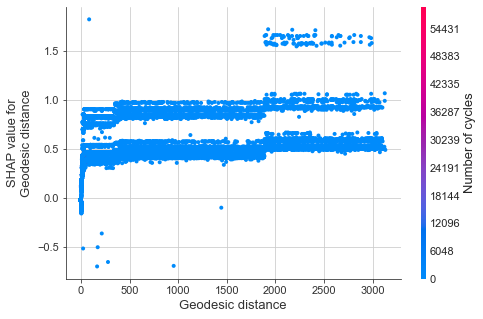

In [68]:
shap.dependence_plot("Geodesic distance", shap_values, X_train, show=False)
#plt.savefig("Shap_Geodesic.pdf")

### Centralities

In [69]:
Nx_bipartite = HG.to_networkx()
deg_cen = nx.degree_centrality(Nx_bipartite)
df_degcen = pd.DataFrame({'claim': [claim for claim in claims_nodes.index],
                          'degree': [deg_cen[claim] for claim in claims_nodes.index] })
df_degcen.head()

,claim,degree
0,000020111059354,0.000002
1,000020111059939,0.000002
2,000020112015244,0.000002
3,000020121000009,0.000003
4,000020121000011,0.000002


In [70]:
df_degcen["degree"].unique()

array([1.70944652e-06, 2.27926202e-06, 2.84907753e-06, 3.41889303e-06,
       4.55852404e-06, 3.98870854e-06, 6.83778606e-06, 5.69815505e-06,
       6.26797056e-06, 5.12833955e-06, 7.97741707e-06, 1.25359411e-05,
       8.54723258e-06, 1.13963101e-05, 1.19661256e-05, 9.68686359e-06,
       9.11704808e-06, 7.40760157e-06, 1.02566791e-05, 1.08264946e-05,
       1.59548341e-05, 1.36755721e-05, 1.31057566e-05, 1.42453876e-05,
       6.09702590e-05, 1.88039117e-05, 1.53850186e-05, 1.70944652e-05,
       1.82340962e-05, 4.04569009e-05, 1.48152031e-05, 1.76642807e-05])

In [71]:
# Centralities take way too long

#cl_cen = nx.closeness_centrality(Nx_bipartite_nobrokers)
    
#df_clocen = pd.DataFrame({'claim': [claim for claim in claims_nodes.index],
#                          'closeness': [cl_cen[claim] for claim in claims_nodes.index] })
#df_clocen.head()

In [72]:
#nx_graph_1 = HG.to_networkx()

In [73]:
#nx_graph_2 = nx.Graph(nx_graph_1)

In [74]:
#import inspect
#print(inspect.getsource(networkit.nxadapter.nx2nk))

In [75]:
#G_nit = networkit.nxadapter.nx2nk(nx_graph_2)

In [76]:
#zipped_nodes = zip(nx_graph_2.nodes(), range(nx_graph_2.number_of_nodes()))
#node_keys = pd.DataFrame(zipped_nodes); node_keys.head()

In [77]:
#round(len(HG.nodes())/1000)

In [78]:
#cl_cen = networkit.centrality.ApproxCloseness(G_nit, 10000).run().ranking()
#cl_cen_df = pd.DataFrame(cl_cen)

In [79]:
#cl_cen_nodes = node_keys.merge(cl_cen_df, left_on = 1, right_on = 0)

In [80]:
#cl_cen_nodes = cl_cen_nodes[["0_x", "1_y"]]
#cl_cen_nodes.columns= ["node_id", "Closeness Centrality"]

In [81]:
#cl_cen_nodes.head()

In [82]:
#btw_cen = networkit.centrality.EstimateBetweenness(G_nit, 10000).run().ranking()

In [83]:
#btw_cen_df = pd.DataFrame(btw_cen)
#btw_cen_nodes = node_keys.merge(btw_cen_df, left_on = 1, right_on = 0)
#btw_cen_nodes = btw_cen_nodes[["0_x", "1_y"]]
#btw_cen_nodes.columns= ["node_id", "Betweenness Centrality"]

#btw_cen_nodes.head()

In [84]:
#centralities = cl_cen_nodes.merge(btw_cen_nodes, on = "node_id")

In [85]:
#centralities.head()

In [86]:
#centralities.to_csv("Centralities.csv", index = False)
centralities = pd.read_csv("Centralities.csv", low_memory=False)

In [88]:
claim_centralities = centralities[centralities["node_id"].isin(claims_nodes.index)].sort_values("node_id").fillna(0)
claim_centralities = claim_centralities.merge(df_degcen, left_on = "node_id", right_on = "claim")[["node_id", "Closeness Centrality", "Betweenness Centrality", "degree"]]
claim_centralities.head()

,node_id,Closeness Centrality,Betweenness Centrality,degree
0,000020111059354,8.734486e-08,8.098172e+04,0.000002
1,000020111059939,8.742829e-08,6.045988e+06,0.000002
2,000020112015244,8.916200e-08,3.012117e+06,0.000002
3,000020121000009,9.030857e-08,1.202886e+07,0.000003
4,000020121000011,8.914239e-08,3.121914e+05,0.000002


In [89]:
claims_centralities_fraud = claim_centralities.merge(labels[["Proven_fraud"]], left_on = "node_id", right_index = True).sort_values("node_id")

In [90]:
claims_centralities_fraud.head()

,node_id,Closeness Centrality,Betweenness Centrality,degree,Proven_fraud
0,000020111059354,8.734486e-08,8.098172e+04,0.000002,0.0
1,000020111059939,8.742829e-08,6.045988e+06,0.000002,0.0
2,000020112015244,8.916200e-08,3.012117e+06,0.000002,0.0
3,000020121000009,9.030857e-08,1.202886e+07,0.000003,0.0
4,000020121000011,8.914239e-08,3.121914e+05,0.000002,0.0


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0523           0.0007           20.84s
         2           0.0535           0.0003           20.28s
         3           0.0529           0.0002           20.48s
         4           0.0525           0.0002           21.06s
         5           0.0526           0.0002           21.51s
         6           0.0521           0.0001           21.83s
         7           0.0526           0.0001           21.61s
         8           0.0509           0.0001           21.54s
         9           0.0524           0.0000           21.21s
        10           0.0525           0.0001           20.91s
        20           0.0515           0.0000           18.68s
        30           0.0508          -0.0000           16.11s
        40           0.0517          -0.0000           13.72s
        50           0.0517          -0.0000           11.45s
        60           0.0516          -0.0000            9.16s
       

Text(0.5, 1.0, 'AUC: 0.695')

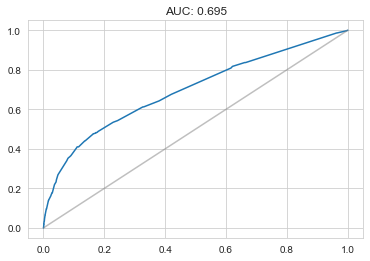

In [91]:
X_train = claims_centralities_fraud.iloc[:train_size, 1:4]
y_train = claims_centralities_fraud.iloc[:train_size, 4]

X_test = claims_centralities_fraud.iloc[train_size:, 1:4]
y_test = claims_centralities_fraud.iloc[train_size:,4]

centrality_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = centrality_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_centrality_model.pdf")

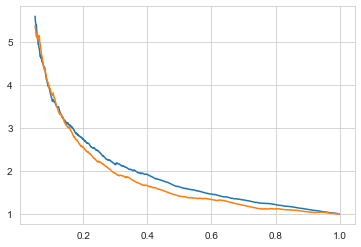

In [92]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)

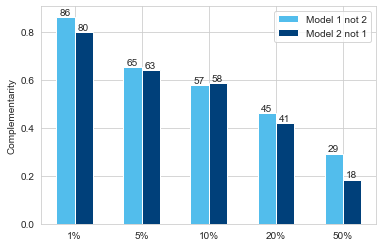

In [93]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_degree.pdf")
plt.show()

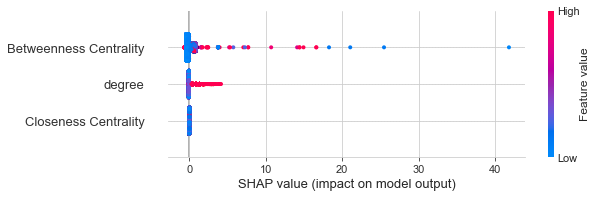

In [94]:
shap_values = shap.TreeExplainer(centrality_model).shap_values(X_train,check_additivity=False)
shap.summary_plot(shap_values, X_train)

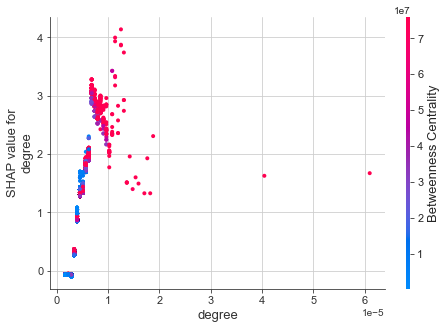

In [95]:
shap.dependence_plot("degree", shap_values, X_train, show=False)
#plt.savefig("Shap_Degree.pdf")

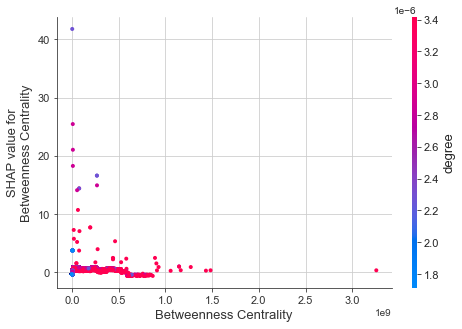

In [96]:
shap.dependence_plot("Betweenness Centrality", shap_values, X_train, show=False)
#plt.savefig("Shap_Betweenness.pdf")

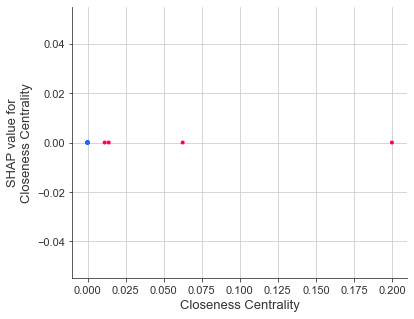

In [97]:
shap.dependence_plot("Closeness Centrality", shap_values, X_train, show = False)
#plt.savefig("Shap_Closeness.pdf")

In [98]:
df_full_cen = claims_centralities_fraud.merge(df_full_geo, left_on = "node_id", right_on = "SI01_NO_SIN")

In [99]:
df_full_cen.columns

Index(['node_id', 'Closeness Centrality', 'Betweenness Centrality', 'degree',
       'Proven_fraud_x', 'Month_Accident', 'Day_Accident', 'Closest_Hour',
       'Reporting_delay', 'SI01_NO_SIN', 'SI01_C_FAM_PROD', 'SI01_C_CAU',
       'Proven_fraud_y', 'AD', 'TI', 'TE', 'Geodesic distance',
       'Number of cycles'],
      dtype='object')

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0523           0.0007           30.90s
         2           0.0534           0.0004           30.59s
         3           0.0527           0.0002           30.25s
         4           0.0522           0.0003           30.04s
         5           0.0523           0.0002           29.75s
         6           0.0518           0.0001           29.31s
         7           0.0523           0.0001           28.95s
         8           0.0506           0.0001           28.62s
         9           0.0520           0.0001           28.17s
        10           0.0520           0.0001           27.83s
        20           0.0505           0.0000           25.48s
        30           0.0489           0.0000           22.66s
        40           0.0492           0.0000           19.51s
        50           0.0491           0.0000           16.18s
        60           0.0491          -0.0000           12.91s
       

Text(0.5, 1.0, 'AUC: 0.793')

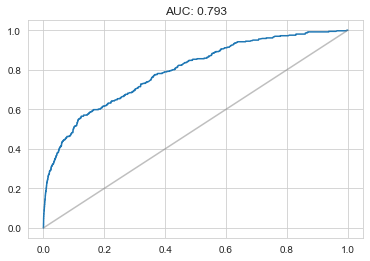

In [100]:
X_full = df_full_cen[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU",
                 "AD", "TI", "TE",
                     "Geodesic distance", "Number of cycles",
                  "Betweenness Centrality", "Closeness Centrality", "degree"]]

y_full = df_full_cen['Proven_fraud_x']

X_train = X_full.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

centrality_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = centrality_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_full_centralities.pdf")

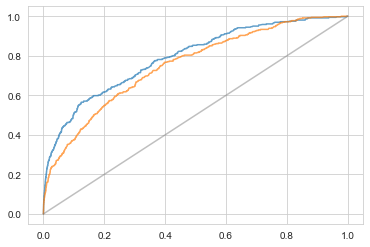

In [101]:
plt.plot(fpr,tpr, alpha = 0.7)
plt.plot(fpr_base, tpr_base, alpha = 0.7)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.savefig("AUC_full_centralities_comp.pdf")

Text(0.5, 1.0, 'Average Precision: 0.017')

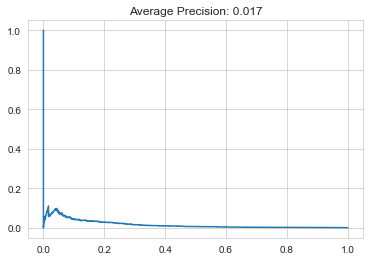

In [102]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))
#plt.savefig("AP_full_centralities.pdf")

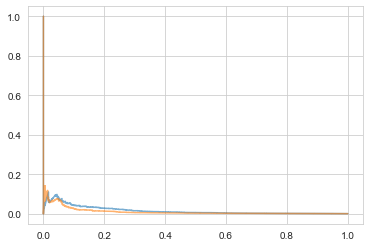

In [103]:
plt.plot(recall,precision, alpha = 0.6)
plt.plot(recall_base,precision_base, alpha = 0.6)
plt.savefig("AP_full_centralities_comp.pdf")

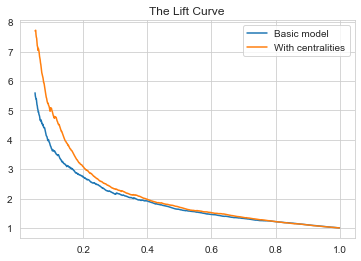

In [104]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "With centralities"))
plt.savefig("Lift_centralities.pdf")

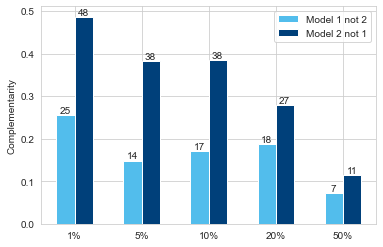

In [105]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_centralities.pdf")
plt.show()

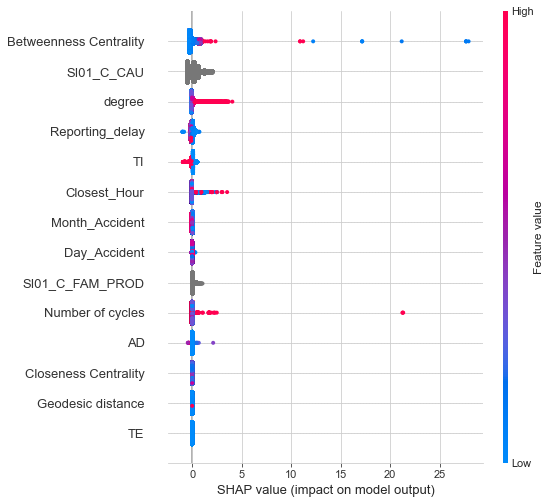

In [106]:
shap_values = shap.TreeExplainer(centrality_model).shap_values(X_train,check_additivity=False)
shap.summary_plot(shap_values, X_train, show = False)
plt.tight_layout()
plt.savefig("Shap_centralities.pdf")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


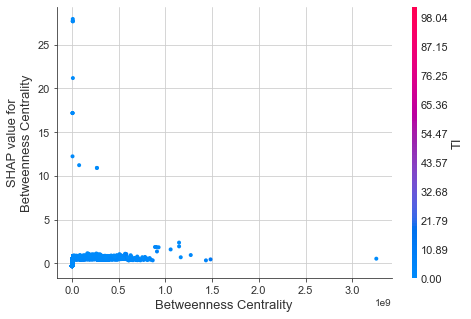

In [107]:
shap.dependence_plot("Betweenness Centrality", shap_values, X_train, show = False)
#plt.savefig("Betweenness_centrality.pdf")

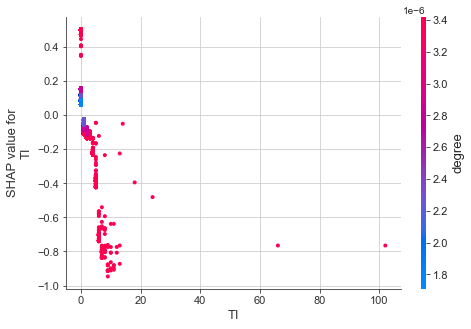

In [108]:
shap.dependence_plot("TI", shap_values, X_train, show = False)
#plt.savefig("TI_fuller.pdf")

# BiRank

In [109]:
ADJ = adjmat_bipartite.transpose().tocsr()
number_claims = ADJ.shape[1]
claims_train = claims_nodes[:train_size]
ADJ_train= ADJ[:,:train_size]
test_set_size = number_claims-train_size
split_size = int(round(train_size/2,0))

HG_parties = np.concatenate((HG.nodes("contract"), HG.nodes("broker"), HG.nodes("counterparty")))
party_nodes = pd.DataFrame({"ID": HG_parties}).set_index("ID")

#First train split
fraud_train = {"FraudInd": labels["Proven_fraud"].values[:split_size]}
fraudMat_train = pd.DataFrame(fraud_train)
validate_set_fraud = {"FraudInd": [0]*(train_size - split_size)}
fraudMat_test_set = pd.DataFrame(validate_set_fraud)
fraudMat_test = fraudMat_train.append(fraudMat_test_set)

Claims_res_1, Parties_res_1, aMat_1, iterations_1, convergence_1 = BiRank(ADJ_train, claims_train, party_nodes, fraudMat_test)

#Final scores for real test set
fraud_score_train_validate = Claims_res_1.sort_values("ID")["Score"].values[:train_size]

fraud_train_res = {"FraudInd": fraud_score_train_validate}
test_set_fraud = {"FraudInd": [0]*test_set_size}
fraudMat_train_res = pd.DataFrame(fraud_train_res)
fraudMat_test_set = pd.DataFrame(test_set_fraud)
fraudMat_test = fraudMat_train_res.append(fraudMat_test_set)

ADJ = adjmat_bipartite.transpose().tocsr()
Claims_res, Parties_res, aMat, iterations, convergence = BiRank(ADJ, claims_nodes, party_nodes, fraudMat_test)

divide by zero encountered in true_divide


Convergence reached.
Convergence reached.


In [110]:
birank_data = claims_nodes.reset_index().merge(Claims_res, left_index = True, right_index = True)[["SI01_NO_SIN", "StdScore"]]

In [111]:
birank_data.head()

,SI01_NO_SIN,StdScore
0,000020111059354,3.516205
1,000020111059939,0.162284
2,000020112015244,-0.100148
3,000020121000009,-0.247143
4,000020121000011,-0.091394


In [112]:
type(Nx_bipartite_nobrokers)

networkx.classes.multigraph.MultiGraph

claims_list = []
claims_set = set(claims_train.index)

nodes_train = set(dict(Nx_bipartite_nobrokers.nodes).keys()).difference(set(claims_nodes[train_size:].index))

Nx_bipartite_nobrokers_train = Nx_bipartite_nobrokers.subgraph(set(dict(Nx_bipartite_nobrokers.nodes).keys()))
Nx_bipartite_nobrokers_train = nx.MultiGraph(Nx_bipartite_nobrokers_train)

n1_q1_list = []
n1_med_list = []
n1_max_list = []

n2_q1_list = []
n2_med_list = []
n2_max_list = []

for claim in tqdm(claims_train.index):
    claims_list.append(claim)
    claim_set = {claim}
    
    n1 = set(nx.generators.ego.ego_graph(Nx_bipartite_nobrokers_train, claim, radius = 2))
    n1 = n1.intersection(claims_set).difference(claim_set)
    n1_scores = birank_data[birank_data["SI01_NO_SIN"].isin(n1)]["StdScore"].quantile([0.25, 0.5,1])
    
    n1_q1_list.append(n1_scores[0.25])
    n1_med_list.append(n1_scores[0.5])
    n1_max_list.append(n1_scores[1])
    
    #n2 = set(nx.generators.ego.ego_graph(Nx_bipartite_nobrokers, claim, radius = 4))
    #n2 = n2.intersection(claims_set).difference(claim_set).difference(n1)
    #n2_scores = birank_data[birank_data["SI01_NO_SIN"].isin(n2)]["StdScore"].quantile([0.25, 0.5,1])
    
    #n2_q1_list.append(n2_scores[0.25])
    #n2_med_list.append(n2_scores[0.5])
    #n2_max_list.append(n2_scores[1])
    

data_neighbours_dict = {"Claims": claims_list, "n1_q1": n1_q1_list, "n1_med": n1_med_list, "n1_max": n1_max_list}
data_neighbours_df = pd.DataFrame(data_neighbours_dict)
data_neighbours_df.to_csv("data_neighbours_train.csv", index = False)

In [113]:
data_neighbours_dict_train = pd.read_csv("data_neighbours_train.csv", low_memory = False)
data_neighbours_dict_train.fillna(0, inplace=True)

claims_list = []
claims_set = set(claims_nodes[train_size:].index)

Nx_bipartite_nobrokers_test = Nx_bipartite_nobrokers

n1_q1_list = []
n1_med_list = []
n1_max_list = []

n2_q1_list = []
n2_med_list = []
n2_max_list = []

for claim in tqdm(claims_nodes[train_size:].index):
    claims_list.append(claim)
    claim_set = {claim}
    
    n1 = set(nx.generators.ego.ego_graph(Nx_bipartite_nobrokers_test, claim, radius = 2))
    n1 = n1.intersection(claims_set).difference(claim_set)
    n1_scores = birank_data[birank_data["SI01_NO_SIN"].isin(n1)]["StdScore"].quantile([0.25, 0.5,1])
    
    n1_q1_list.append(n1_scores[0.25])
    n1_med_list.append(n1_scores[0.5])
    n1_max_list.append(n1_scores[1])

data_neighbours_dict = {"Claims": claims_list, "n1_q1": n1_q1_list, "n1_med": n1_med_list, "n1_max": n1_max_list}
data_neighbours_df = pd.DataFrame(data_neighbours_dict)
data_neighbours_df.to_csv("data_neighbours_test.csv", index = False)

In [114]:
data_neighbours_dict_test = pd.read_csv("data_neighbours_test.csv", low_memory = False)
data_neighbours_dict_test.fillna(0, inplace=True)

In [115]:
data_neighbours_dict_train.head()

,Claims,n1_q1,n1_med,n1_max
0,20111059354,3.516205,3.516205,8.235445
1,20111059939,0.280419,0.280419,0.280419
2,20112015244,-0.100148,-0.100148,-0.100148
3,20121000009,0.000000,0.000000,0.000000
4,20121000011,-0.091394,-0.091394,-0.091394


In [116]:
data_neighbours_dict_test.head()

,Claims,n1_q1,n1_med,n1_max
0,20171015047,0.000000,0.000000,0.000000
1,20171015048,-0.200209,-0.186091,1.227134
2,20171015049,0.356640,0.356640,0.356640
3,20171015050,-0.042137,0.028808,0.900835
4,20171015051,0.000000,0.000000,0.000000


In [117]:
data_neighbours_dict_full = data_neighbours_dict_train.append(data_neighbours_dict_test)

In [118]:
data_neighbours_dict_full = data_neighbours_dict_full.sort_values("Claims").reset_index(drop=True)

In [119]:
BiRank_data_df = Claims_res.sort_values("ID")[["StdScore"]].merge(data_neighbours_dict_full, left_index=True, right_index=True)
BiRank_data_df.head()

,StdScore,Claims,n1_q1,n1_med,n1_max
0,3.516205,20111059354,3.516205,3.516205,8.235445
1,0.162284,20111059939,0.280419,0.280419,0.280419
2,-0.100148,20112015244,-0.100148,-0.100148,-0.100148
3,-0.247143,20121000009,0.000000,0.000000,0.000000
4,-0.091394,20121000011,-0.091394,-0.091394,-0.091394


In [121]:
X_full = BiRank_data_df.sort_values("Claims")[["StdScore", "n1_q1", "n1_med", "n1_max"]]

y_full = df_full_cen.sort_values("node_id")['Proven_fraud_x']

X_train = X_full.iloc[split_size:train_size, :]
y_train = y_full[split_size:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0472           0.0011           13.04s
         2           0.0470           0.0004           13.10s
         3           0.0468           0.0002           12.77s
         4           0.0455           0.0001           12.64s
         5           0.0471           0.0001           12.43s
         6           0.0455           0.0001           12.31s
         7           0.0463           0.0000           12.14s
         8           0.0473           0.0001           12.00s
         9           0.0452          -0.0000           11.88s
        10           0.0467           0.0000           11.79s
        20           0.0467          -0.0000           10.37s
        30           0.0457           0.0000            9.05s
        40           0.0452           0.0000            7.76s
        50           0.0453          -0.0000            6.52s
        60           0.0449          -0.0000            5.25s
       

Text(0.5, 1.0, 'AUC: 0.593')

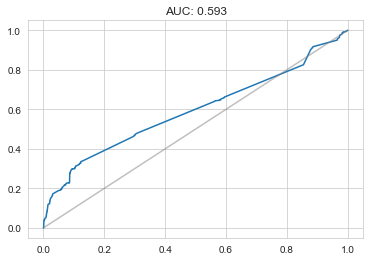

In [122]:
birank_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = birank_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

Text(0.5, 1.0, 'Average Precision: 0.004')

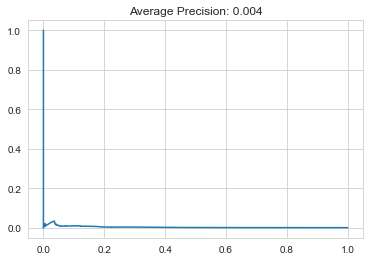

In [123]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))

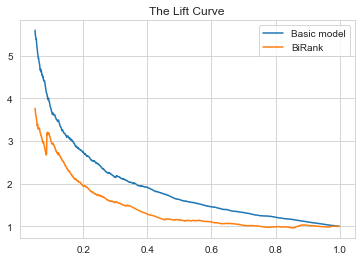

In [124]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "BiRank"))
plt.savefig("Lift_BiRanksimple.pdf")

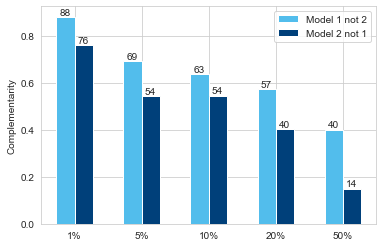

In [125]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_BiRankBase.pdf")
plt.show()

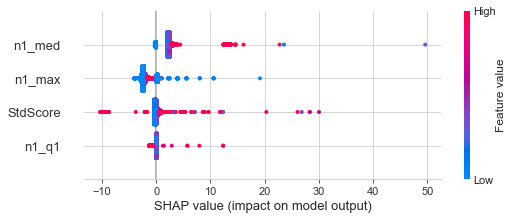

In [126]:
shap_values = shap.TreeExplainer(birank_model).shap_values(X_train,check_additivity=False)
shap.summary_plot(shap_values, X_train)

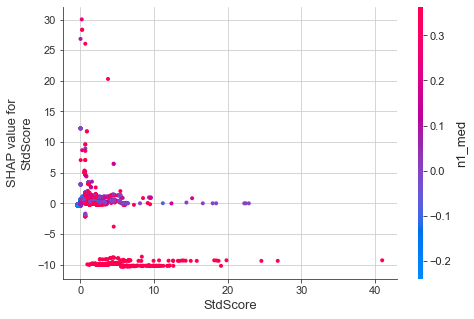

In [127]:
shap.dependence_plot("StdScore", shap_values, X_train)

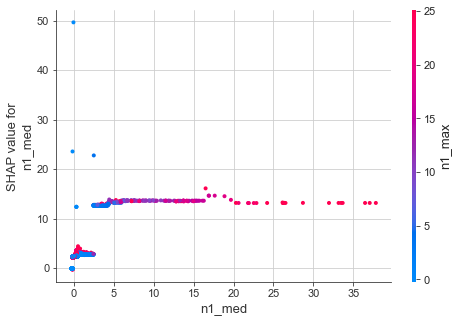

In [128]:
shap.dependence_plot("n1_med", shap_values, X_train)

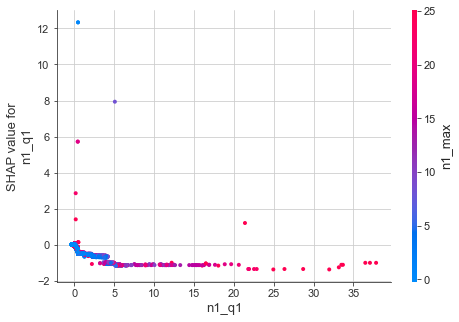

In [129]:
shap.dependence_plot("n1_q1", shap_values, X_train)

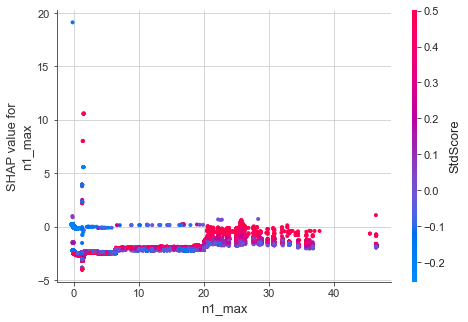

In [130]:
shap.dependence_plot("n1_max", shap_values, X_train)

In [131]:
df_full_birank = df_full_cen.merge(X_full, left_index = True, right_index = True)

In [132]:
df_full_birank.columns

Index(['node_id', 'Closeness Centrality', 'Betweenness Centrality', 'degree',
       'Proven_fraud_x', 'Month_Accident', 'Day_Accident', 'Closest_Hour',
       'Reporting_delay', 'SI01_NO_SIN', 'SI01_C_FAM_PROD', 'SI01_C_CAU',
       'Proven_fraud_y', 'AD', 'TI', 'TE', 'Geodesic distance',
       'Number of cycles', 'StdScore', 'n1_q1', 'n1_med', 'n1_max'],
      dtype='object')

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0472           0.0011           16.00s
         2           0.0469           0.0004           15.98s
         3           0.0468           0.0002           15.74s
         4           0.0454           0.0002           15.63s
         5           0.0470           0.0001           15.48s
         6           0.0453           0.0001           15.33s
         7           0.0461           0.0000           15.13s
         8           0.0470           0.0001           14.92s
         9           0.0449           0.0001           14.75s
        10           0.0462           0.0000           14.59s
        20           0.0465           0.0000           12.95s
        30           0.0450           0.0000           11.44s
        40           0.0444          -0.0000            9.91s
        50           0.0440          -0.0000            8.29s
        60           0.0440           0.0000            6.67s
       

Text(0.5, 1.0, 'AUC: 0.759')

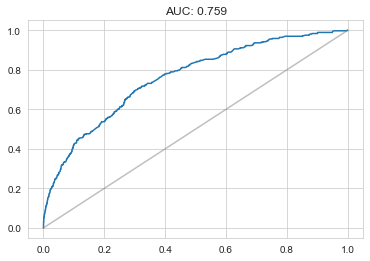

In [133]:
X_full = df_full_birank[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU",
                        "StdScore", "n1_q1", "n1_med", "n1_max"]]

y_full = df_full_cen['Proven_fraud_x']

X_train = X_full.iloc[split_size:train_size, :]
y_train = y_full[split_size:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

birank_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = birank_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
#plt.savefig("AUC_full_birank.pdf")

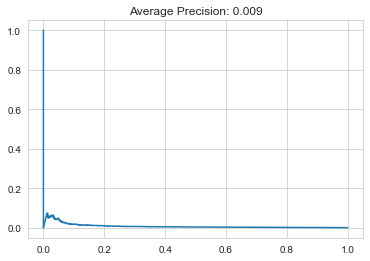

In [134]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))
plt.savefig("AP_full_birank.pdf")

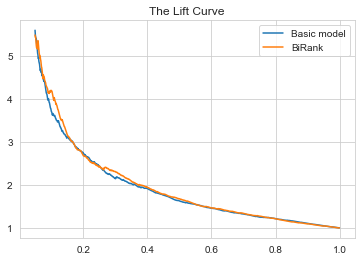

In [135]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "BiRank"))
plt.savefig("Lift_BiRankfull.pdf")

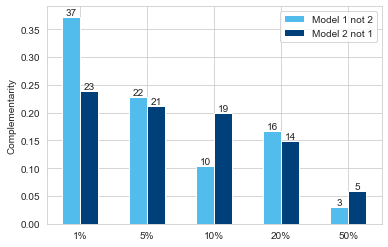

In [136]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_BiRank.pdf")
plt.show()

In [137]:
shap_values = shap.TreeExplainer(birank_model).shap_values(X_train,check_additivity=False)

In [138]:
shap_values_cap = np.clip(shap_values, -50,50)

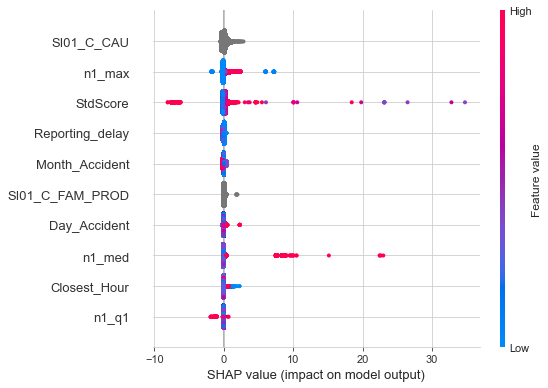

In [139]:
shap.summary_plot(shap_values_cap, X_train, show = False)
plt.tight_layout()
plt.savefig("BiRank_shap_summary_capped.pdf")

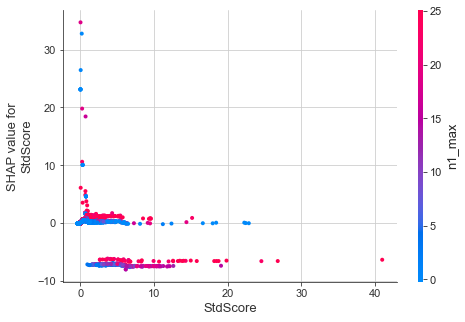

In [140]:
shap.dependence_plot("StdScore", shap_values, X_train, show = False)
plt.savefig("Shap_StdScore.pdf")

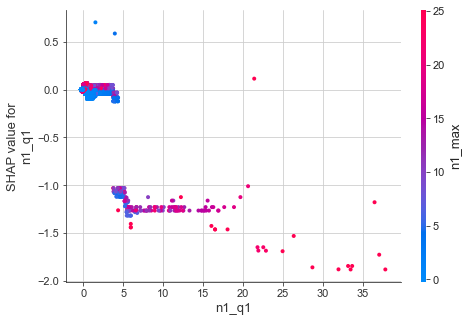

In [141]:
shap.dependence_plot("n1_q1", shap_values, X_train, show = False)
plt.savefig("Shap_Birankq1.pdf")

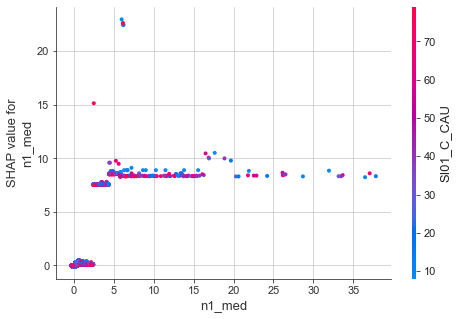

In [142]:
shap.dependence_plot("n1_med", shap_values, X_train, show = False)
plt.savefig("Shap_Birankmed.pdf")

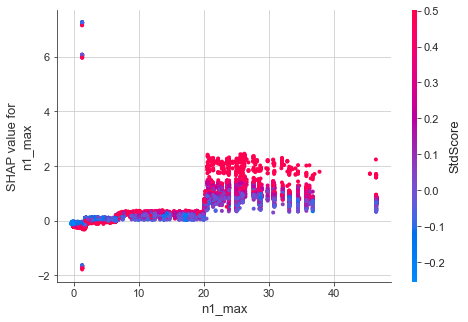

In [143]:
shap.dependence_plot("n1_max", shap_values, X_train, show = False)
plt.savefig("Shap_Birankmax.pdf")

# Embedding

In [144]:
from BipartiteFunctions import Metapath2vec

In [145]:
metapaths = [
    ["claim", "counterparty", "claim"],
    ["claim", "contract","claim"],
    ["claim", "broker", "claim"]
]
#node_ids, node_embeddings, node_targets = Metapath2vec(HG, metapaths, dimensions = 20, num_walks = 2, walk_length = 9, context_window_size = 10)

In [146]:
#bet_cen = nx.betweenness_centrality(nx.Graph(Nx_bipartite), k = 66)
#df_betcen = pd.DataFrame({'claim': [claim for claim in claims_nodes.index],
#                          'betweenness': [bet_cen[claim] for claim in claims_nodes.index] })
#df_betcen.head()

In [147]:
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec
import multiprocessing

In [148]:
dimensions = 20
num_walks = 2
walk_length = 9
context_window_size = 10

workers = multiprocessing.cpu_count()
#print(workers)

rw = UniformRandomMetaPathWalk(HG)
walks = rw.run(
    HG.nodes(), n=num_walks, length=walk_length, metapaths=metapaths
)

#walks = pd.read_csv("randomWalks.csv")
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 3937824


In [149]:
model = Word2Vec(
    walks,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=workers,
    vector_size=dimensions
)

node_ids = model.wv.index_to_key  # list of node IDs


node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [HG.node_type(node_id) for node_id in node_ids]

In [150]:
type(walks)

list

In [151]:
#pd.DataFrame(walks).to_csv("randomWalks.csv", index=False)

In [152]:
embedding_df = pd.DataFrame(node_embeddings)

In [153]:
embedding_df.index = node_ids

In [154]:
embedding_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
00000001,-1.379613,-2.544270,-3.640570,-0.204610,1.672616,1.902689,-0.203128,-0.590981,0.785864,2.044038,2.013340,2.209335,-1.505701,-1.280191,-0.474488,-0.835388,0.126656,-0.228861,-3.891300,-0.150811
10033001,1.380759,-2.800497,-0.125179,-2.384368,3.459720,1.098348,-1.031077,-2.677542,0.136908,0.148662,0.632198,-2.065579,0.973317,-0.714199,-3.917090,-1.923278,0.865898,-2.472567,-0.963205,-0.867076
010102120000022,-1.331063,-3.477080,-5.482292,-3.240120,2.735839,2.167067,-0.727387,-0.758096,1.708246,2.273103,0.896649,3.971187,-2.284657,0.214468,-0.768676,-1.123291,0.924707,-2.083985,-2.761604,2.982381
010102120000009,-1.778779,-2.498264,-4.388968,-1.681448,1.848643,2.947823,-0.454518,-0.241353,-0.068297,1.553956,4.111709,3.200083,-1.598697,-4.931205,-2.058571,0.598782,2.247740,-1.350342,-2.785856,-1.292625
010502110000419,3.321955,-4.017447,-1.172093,-1.717290,3.943861,2.643853,-4.193240,-3.493989,-0.122175,-0.878259,-1.069988,2.323106,1.155429,0.910279,-4.657700,-1.368369,1.392471,-3.438575,-3.688993,-2.131455


In [155]:
claim_embedding_df = embedding_df.loc[list(claims_nodes.index)]

In [156]:
embedding_fraud = claim_embedding_df.merge(labels, left_index=True, right_index=True)

In [159]:
train_size = int(round(0.6*len(embedding_fraud),0))

X_train = embedding_fraud.iloc[:train_size, :20]
y_train = embedding_fraud.iloc[:train_size, 20]

X_test = embedding_fraud.iloc[train_size:, :20]
y_test = embedding_fraud.iloc[train_size:, 20]

In [160]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [161]:
embedding_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0531          -0.0002            2.50m
         2           0.0546          -0.0002            2.45m
         3           0.0541           0.0000            2.42m
         4           0.0538           0.0001            2.38m
         5           0.0539           0.0001            2.34m
         6           0.0534           0.0000            2.30m
         7           0.0540           0.0001            2.28m
         8           0.0522          -0.0000            2.25m
         9           0.0538          -0.0003            2.22m
        10           0.0538          -0.0003            2.19m
        20           0.0525           0.0000            1.94m
        30           0.0519          -0.0004            1.70m
        40           0.0522           0.0000            1.45m
        50           0.0520           0.0000            1.21m
        60           0.0519          -0.0000           58.00s
       

Text(0.5, 1.0, 'AUC: 0.622')

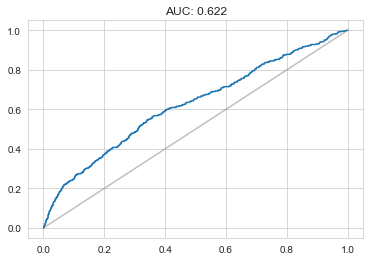

In [162]:
y_pred = embedding_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))

Text(0.5, 1.0, 'Average Precision: 0.003')

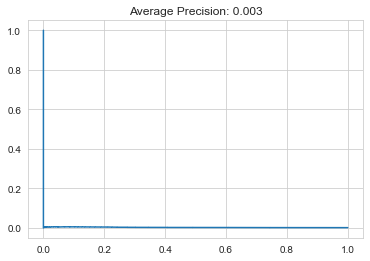

In [163]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))

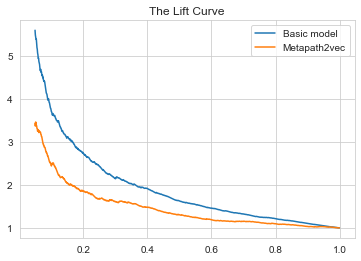

In [164]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "Metapath2vec"))
plt.savefig("Lift_metasimple.pdf")

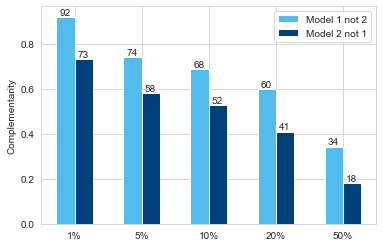

In [165]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_MetapathSimple.pdf")
plt.show()

In [166]:
#pd.read_csv("randomWalks.csv")

In [167]:
embedding_fraud.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,Proven_fraud,Investigated_case
000020111059354,-1.062263,-0.723557,-1.798942,-1.418340,0.328848,0.898413,0.745326,-0.765553,0.202700,0.363196,...,0.421044,0.097856,-1.373648,1.201953,-0.771085,-0.535713,-0.022468,-0.894223,0.0,0.0
000020111059939,-0.409535,-1.350179,-0.168755,0.473630,1.008866,0.479484,0.482144,-1.046220,1.669227,-0.811069,...,-0.467659,-1.258540,-0.636543,1.118332,-0.977762,0.137117,-0.038182,-0.447431,0.0,0.0
000020112015244,0.220756,-0.287644,-0.912204,-0.160221,0.276063,1.554189,1.114771,-1.658078,0.253973,-1.153161,...,0.716758,-0.480022,-0.536082,0.775537,0.724380,-0.966877,-1.026747,-0.019705,0.0,0.0
000020121000009,0.124473,-2.004739,-1.060776,0.415130,0.885420,1.041609,-0.817063,-0.819170,0.818426,-0.320332,...,0.069960,0.446454,0.431124,0.670033,-0.650860,-1.011056,-0.854424,0.396220,0.0,0.0
000020121000011,-1.342829,-1.492543,-0.357407,-0.036046,0.422724,0.578226,0.825951,-1.168701,0.281260,0.981672,...,1.029074,-0.542629,-1.648437,0.403474,-0.427428,0.628001,-0.713102,-0.100582,0.0,0.0


In [168]:
df_full_geo.head()

,Month_Accident,Day_Accident,Closest_Hour,Reporting_delay,SI01_NO_SIN,SI01_C_FAM_PROD,SI01_C_CAU,Proven_fraud,AD,TI,TE,Geodesic distance,Number of cycles
0,1,1,12.0,51,000020111059354,0.0,77.0,0.0,0.0,0.0,0.0,4.0,1.0
1,4,0,17.0,4,000020111059939,0.0,8.0,0.0,0.0,0.0,0.0,4.0,1.0
2,1,2,12.0,20,000020112015244,12.0,11.0,0.0,0.0,0.0,0.0,4.0,1.0
3,1,0,12.0,1,000020121000009,1.0,55.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,12.0,0,000020121000011,0.0,67.0,0.0,0.0,0.0,0.0,4.0,1.0


In [169]:
df_full_meta = embedding_fraud.merge(df_full_cen, left_index = True, right_on = "SI01_NO_SIN")

In [170]:
df_full_meta.columns

Index([                       0,                        1,
                              2,                        3,
                              4,                        5,
                              6,                        7,
                              8,                        9,
                             10,                       11,
                             12,                       13,
                             14,                       15,
                             16,                       17,
                             18,                       19,
                 'Proven_fraud',      'Investigated_case',
                      'node_id',   'Closeness Centrality',
       'Betweenness Centrality',                 'degree',
               'Proven_fraud_x',         'Month_Accident',
                 'Day_Accident',           'Closest_Hour',
              'Reporting_delay',            'SI01_NO_SIN',
              'SI01_C_FAM_PROD',             'SI01_C_CAU

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0523           0.0007            2.84m
         2           0.0534           0.0004            2.83m
         3           0.0527           0.0002            2.82m
         4           0.0523           0.0003            2.76m
         5           0.0523           0.0002            2.71m
         6           0.0518          -0.0001            2.68m
         7           0.0524           0.0001            2.66m
         8           0.0506          -0.0002            2.64m
         9           0.0522           0.0000            2.62m
        10           0.0523           0.0001            2.59m
        20           0.0508           0.0000            2.25m
        30           0.0493           0.0000            1.95m
        40           0.0493           0.0000            1.66m
        50           0.0488           0.0001            1.39m
        60           0.0486           0.0000            1.13m
       

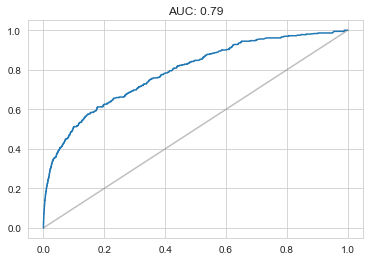

In [171]:
X_full = df_full_meta[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU",
                 "AD", "TI", "TE",
                     "Geodesic distance", "Number of cycles",
                  "Betweenness Centrality", "Closeness Centrality","degree",
                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
                        12,                  13,                  14,
                        15,                  16,                  17,
                        18,                  19]]

y_full = df_full_meta['Proven_fraud_x']

X_train = X_full.iloc[:train_size, :]
y_train = y_full[:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

meta_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = meta_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_metapath_full_pitch.pdf")

Text(0.5, 1.0, 'Average Precision: 0.016')

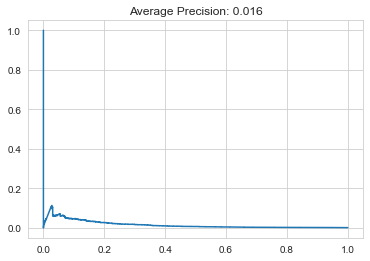

In [172]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))
#plt.savefig("AP_metapath_full.pdf")

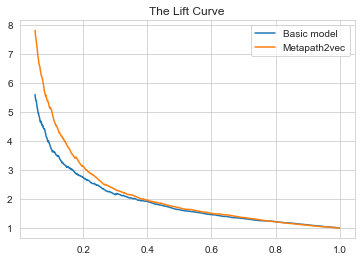

In [173]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "Metapath2vec"))
plt.savefig("Lift_metafull.pdf")

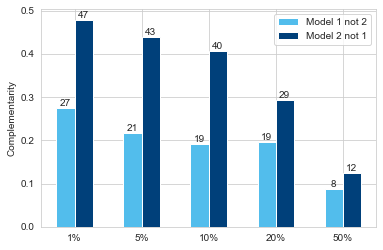

In [174]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_Metapath.pdf")
plt.show()

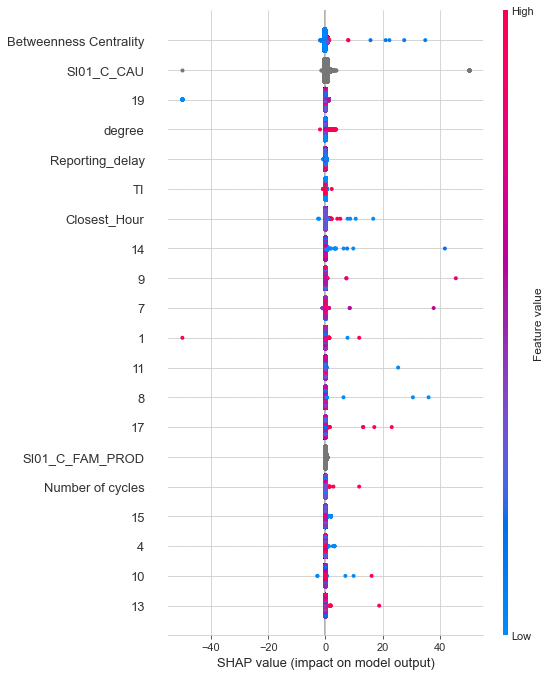

In [175]:
shap_values = shap.TreeExplainer(meta_model).shap_values(X_train,check_additivity=False)
shap_values_cap = np.clip(shap_values, -50,50)
shap.summary_plot(shap_values_cap, X_train, show = False)
plt.tight_layout()
plt.savefig("metapath_shap_summary_cap.pdf")

In [176]:
claims_txt = ["0000"+str(x) for x in BiRank_data_df.Claims]
BiRank_data_df["Claims_Num"] = claims_txt

In [1]:
df_full_meta_birank = df_full_meta.merge(BiRank_data_df, left_on = "SI01_NO_SIN", right_on = "Claims_Num")
df_full_meta_birank = df_full_meta_birank.sort_values("Claims_Num")


NameError: name 'df_full_meta' is not defined

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0472           0.0010            1.52m
         2           0.0472           0.0003            1.48m
         3           0.0468           0.0002            1.46m
         4           0.0455           0.0002            1.44m
         5           0.0469           0.0001            1.41m
         6           0.0453           0.0001            1.41m
         7           0.0462           0.0001            1.39m
         8           0.0469           0.0001            1.38m
         9           0.0449           0.0001            1.37m
        10           0.0463           0.0000            1.36m
        20           0.0463           0.0001            1.20m
        30           0.0451          -0.0000            1.05m
        40           0.0445          -0.0000           54.60s
        50           0.0440          -0.0000           45.39s
        60           0.0434          -0.0000           36.68s
       

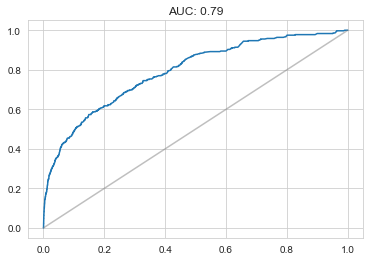

In [178]:
X_full = df_full_meta_birank[["Month_Accident", "Closest_Hour", "Reporting_delay", "Day_Accident", "SI01_C_FAM_PROD","SI01_C_CAU",
                 "AD", "TI", "TE",
                     "Geodesic distance", "Number of cycles",
                  "Betweenness Centrality", "Closeness Centrality","degree",
                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,                  10,                  11,
                        12,                  13,                  14,
                        15,                  16,                  17,
                        18,                  19, 
                      "StdScore","n1_q1", "n1_med", "n1_max"]]

y_full = df_full_meta_birank['Proven_fraud_x']

X_train = X_full.iloc[split_size:train_size, :]
y_train = y_full[split_size:train_size]

X_test = X_full.iloc[train_size:, :]
y_test = y_full[train_size:]

meta_birank_model = GradientBoostingClassifier(n_estimators=100, subsample = 0.8,max_depth=2, random_state=1997, verbose = 1).fit(X_train, y_train)
y_pred = meta_birank_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.title("AUC: "+str(np.round(metrics.auc(fpr, tpr),3)))
plt.savefig("AUC_metapath_birank_full.pdf")

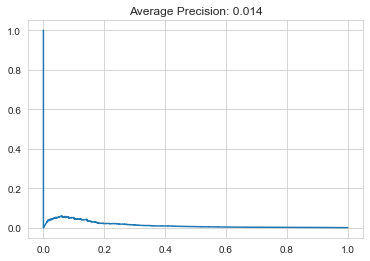

In [179]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test,y_pred)
plt.plot(recall,precision)
plt.title("Average Precision: "+str(np.round(metrics.average_precision_score(y_test, y_pred),3)))
plt.savefig("AP_metapath_birank_full.pdf")

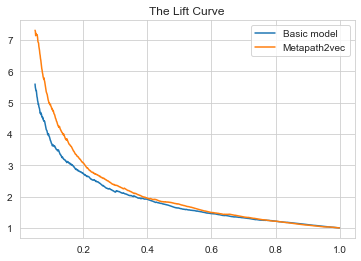

In [180]:
steps = np.arange(start = 0.05, stop = 1, step = 0.001)
lft = lift_curve_values(y_test, y_pred, steps)
plt.plot(steps, lft_base)
plt.plot(steps, lft)
plt.title("The Lift Curve")
plt.legend( ("Basic model", "Metapath2vec"))
plt.savefig("Lift_final_full.pdf")

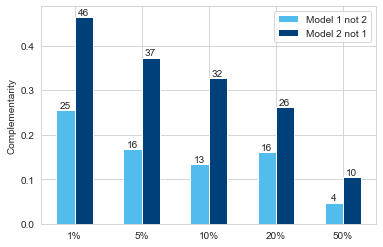

In [183]:
Y_pred = pd.DataFrame() 
Y_pred['real'] = y_test
Y_pred['1'] = y_base_pred
Y_pred['2'] = y_pred

percentages = [1, 5, 10, 20, 50]
complementarity_12 = []
complementarity_21 = []

for i in percentages:
    p = i/100
    comp_12, comp_21 = complementarity_measure(Y_pred, p)
    complementarity_12.append(comp_12)
    complementarity_21.append(comp_21)

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind-width/2, complementarity_12, width, color ="#52BDEC")
rects2 = ax.bar(ind+width/2, complementarity_21, width, color = "#00407A")

ax.set_ylabel('Complementarity')
ax.set_xticks(ind)
ax.set_xticklabels( ('1%', '5%', '10%', '20%', '50%') )
ax.legend( (rects1[0], rects2[0]), ('Model 1 not 2', 'Model 2 not 1') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h*100),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.savefig("Complementary_Full.pdf")
plt.show()

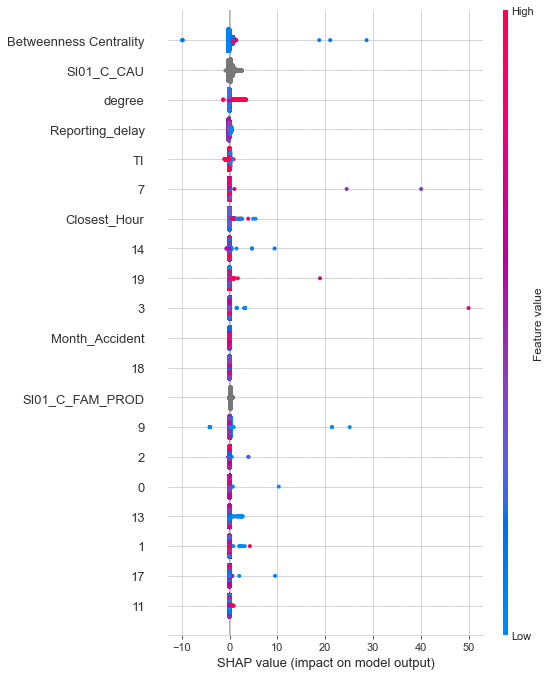

In [184]:
shap_values = shap.TreeExplainer(meta_model).shap_values(X_train,check_additivity=False)
shap_values_cap = np.clip(shap_values, -50,50)
shap.summary_plot(shap_values_cap, X_train, show = False)
plt.tight_layout()
plt.savefig("metapath_birank_shap_summary_cap.pdf")

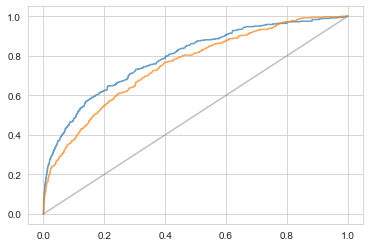

In [188]:
plt.plot(fpr,tpr, alpha =0.7)
plt.plot(fpr_base, tpr_base, alpha =0.7)
plt.plot([0,1], [0,1], color = "grey", alpha = 0.5)
plt.savefig("meta_birank_AUC_comp.pdf")

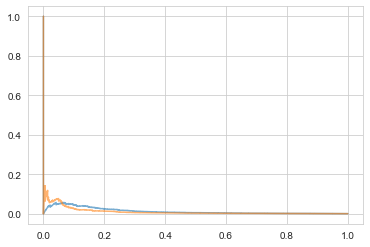

In [189]:
plt.plot(recall,precision, alpha =0.6)
plt.plot(recall_base, precision_base, alpha =0.6)
plt.savefig("AP_metapath_birank_full_comp.pdf")